In [2]:
import sys
sys.path.append('./code')
from importlib import reload

In [3]:
from config import row_colors, columns_to_names, row_colors_dict

In [4]:
import make_figure4
reload(make_figure4)
from make_figure4 import *
import pickle

goodinds = pickle.load(open('./for_snipping/goodinds', 'rb'))
merged_clustdict = pickle.load(open('./for_snipping/merged_clustdict', 'rb'))
merged_inds_to_subset = pickle.load(open('./for_snipping/merged_inds_to_subset', 'rb'))


cooldict_50kb = pickle.load(open('./for_snipping/cooldict_50kb', 'rb'))
ind_to_gene = pickle.load(open('./for_snipping/ind_to_gene', 'rb'))
all_ind_to_region = pickle.load(open('./for_snipping/all_ind_to_region', 'rb'))

my_treg_comp = pickle.load(open('./for_snipping/my_treg_comp', 'rb'))

1
1


In [5]:
%load_ext autoreload
%autoreload
import scanpy as sc

sc.settings.set_figure_params(dpi=80, color_map='coolwarm', frameon=True)
plt.rcParams.update({'font.size': 12})
plt.rcParams.update({"axes.grid.axis" : 'both'})
plt.rcParams.update({"axes.grid" : True})

plt.rcParams.update({
    'axes.labelsize': 14,       # x and y labels' font size
    'xtick.labelsize': 8,      # x tick labels' font size
    'ytick.labelsize': 8,      # y tick labels' font size
    'axes.titlesize': 14,        # Axes title font size
    'patch.linewidth' : .35,
    'lines.linewidth' : .5,
    'legend.fontsize': 6,      # Legend font size
})
plt.rcParams['pdf.fonttype'] = 42

plt.rcParams.update({
    'axes.labelsize': 8,       # x and y labels' font size
    'xtick.labelsize': 6,      # x tick labels' font size
    'ytick.labelsize': 6,      # y tick labels' font size
    'axes.titlesize': 10,        # Axes title font size
    'patch.linewidth' : .35,
    'lines.linewidth' : .5,
    'xtick.major.pad' : 2,
    'ytick.major.pad' : 2,

})
plt.rcParams['axes.linewidth'] = .25
plt.rcParams['xtick.major.width'] = .25
plt.rcParams['ytick.major.width'] = .25
plt.rcParams['ytick.major.size'] = 2
plt.rcParams['xtick.major.size'] = 2
plt.rcParams['grid.linewidth'] = .25

plt.rcParams['axes.facecolor'] = 'none' # Or any suitable colour...
plt.rcParams['figure.facecolor'] = 'none'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['savefig.facecolor'] = 'none'

In [6]:
%load_ext autoreload
%autoreload 2
from hub_pileup import *
from compute_differential_hic_hub import *
from collections import defaultdict
from make_figure4 import *
import itertools
import cooler

our_treg_250kb = cooler.Cooler('/Genomics/argo/users/gdolsten/pritlab/mega_tcell_dataset/zoomified_merged_cools/Rename_Treg_all_no_chrM.mcool::/resolutions/250000')

our_treg_25kb = cooler.Cooler('/Genomics/argo/users/gdolsten/pritlab/mega_tcell_dataset/zoomified_merged_cools/Rename_Treg_all_no_chrM.mcool::/resolutions/25000')
our_tcon_25kb = cooler.Cooler('/Genomics/argo/users/gdolsten/pritlab/mega_tcell_dataset/zoomified_merged_cools/Rename_Tconv_all_no_chrM.mcool::/resolutions/25000')



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
HI


In [7]:
from initialize import *
import cooler 

treg_250kb = cooler.Cooler('./Treg_all.mcool::/resolutions/250000')

(chromsizes, parsed_chroms, region_to_inds, 
    all_region_to_ind, inds_to_region, all_ind_to_region, 
    chrom_to_start, chrom_to_end) = initialize_helper_vars(treg_250kb)


In [10]:
inter_and_intra_connections_treg = pickle.load(open('./for_snipping/inter_and_intra_connections_treg', 'rb'))
inter_and_intra_connections_tcon = pickle.load(open('./for_snipping/inter_and_intra_connections_tcon', 'rb'))

In [17]:
PARSED_CHROMS_chr = {'chr' + x : y for x, y in chrom_to_start.items()}
PARSED_CHROMS = {x : y for x, y in chrom_to_start.items()}

In [1]:
%autoreload 2
from hub_pileup import pileup_bin_pairs

padding_size = 50
metadomain_pileup_cooldict = {
    'Our_Treg' : our_treg_25kb,
    'Our_Tcon' : our_tcon_25kb,
}

rows_cluster0 = []
for chrom in PARSED_CHROMS:
    s, e = chrom_to_start[chrom], chrom_to_end[chrom]
    df = pd.DataFrame()
    df['ind'] = np.arange(len(all_ind_to_region))
    df['chrom'] = ['chr' + all_ind_to_region[x][0] for x in range(len(all_ind_to_region))]
    df['cluster'] = -1
    df.loc[goodinds, 'cluster'] = merged_clustdict['all']
    df = df.iloc[s:e]
    
    df2 = pd.DataFrame()
    df2['ind'] = goodinds
    df2['chrom'] = ['chr' + all_ind_to_region[x][0] for x in goodinds]
    df2['cluster'] = merged_clustdict['all']
    df2 = df2[df2['cluster'].isin([0])]
    
    all_mat_dict, all_metadata = pileup_bin_pairs(df, df2, metadomain_pileup_cooldict, 
                                                                  PARSED_CHROMS_chr, 
                                                                  inter_and_intra_connections_treg, 
                                                                  inter_and_intra_connections_tcon, 
                                                                  padding_size=padding_size, 
                                                                  fetch_oe=True,
                                                                  resolution_out = 25_000
                        )
        
    for u in all_metadata['ind1'].unique():
        idx = (all_metadata['ind1'] == u) & (all_metadata['cluster2'] == 0)
        submat = all_mat_dict['Our_Treg'][idx]
        inside_filt, outside_filt = make_sideways_filt(submat.shape[1]//2, 5, delta=20)
        inside_filt = np.roll(inside_filt, 5, axis=1)
        inside_filt = np.roll(inside_filt, 5, axis=0)
        outside_filt = np.roll(outside_filt, 5, axis=1)
        outside_filt = np.roll(outside_filt, 5, axis=0)
        v_middle, v_outside = get_inside_outside(submat, inside_filt, outside_filt)
        stat, p, delta, _, _ = test_inside_outside_baseline(v_middle, v_outside, cliplo=-1, cliphigh=10)
        rows_cluster0.append([u, stat, p, delta,])


In [5]:
%autoreload 2
from hub_pileup import pileup_bin_pairs

padding_size = 50
metadomain_pileup_cooldict = {
    'Our_Treg' : our_treg_25kb,
    'Our_Tcon' : our_tcon_25kb,
}

rows_cluster1 = []
for chrom in PARSED_CHROMS:
    s, e = chrom_to_start[chrom], chrom_to_end[chrom]
    df = pd.DataFrame()
    df['ind'] = np.arange(len(all_ind_to_region))
    df['chrom'] = ['chr' + all_ind_to_region[x][0] for x in range(len(all_ind_to_region))]
    df['cluster'] = -1
    df.loc[goodinds, 'cluster'] = merged_clustdict['all']
    df = df.iloc[s:e]
    
    df2 = pd.DataFrame()
    df2['ind'] = goodinds
    df2['chrom'] = ['chr' + all_ind_to_region[x][0] for x in goodinds]
    df2['cluster'] = merged_clustdict['all']
    df2 = df2[df2['cluster'].isin([4])]
    
    all_mat_dict, all_metadata = pileup_bin_pairs(df, df2, metadomain_pileup_cooldict, 
                                                                  PARSED_CHROMS_chr, 
                                                                  inter_and_intra_connections_treg, 
                                                                  inter_and_intra_connections_tcon, 
                                                                  padding_size=padding_size, 
                                                                  fetch_oe=True,
                                                                  resolution_out = 25_000
                        )
        

    
    for u in all_metadata['ind1'].unique():
        idx = (all_metadata['ind1'] == u) & (all_metadata['cluster2'] == 4)
        submat = all_mat_dict['Our_Treg'][idx]
        inside_filt, outside_filt = make_sideways_filt(submat.shape[1]//2, 5, delta=20)
        inside_filt = np.roll(inside_filt, 5, axis=1)
        inside_filt = np.roll(inside_filt, 5, axis=0)
        outside_filt = np.roll(outside_filt, 5, axis=1)
        outside_filt = np.roll(outside_filt, 5, axis=0)
        v_middle, v_outside = get_inside_outside(submat, inside_filt, outside_filt)
        stat, p, delta, _, _ = test_inside_outside_baseline(v_middle, v_outside, cliplo=-1, cliphigh=10)
        rows_cluster1.append([u, stat, p, delta,])


In [232]:
data0 = pd.DataFrame(rows_cluster0, columns = ['ind', 'stat', 'p', 'delta']).set_index('ind')
data1 = pd.DataFrame(rows_cluster1, columns = ['ind', 'stat', 'p', 'delta']).set_index('ind')

df = pd.DataFrame()
df['ind'] = np.arange(len(all_ind_to_region))
df['chrom'] = ['chr' + all_ind_to_region[x][0] for x in range(len(all_ind_to_region))]
df['cluster'] = -1
df.loc[goodinds, 'cluster'] = merged_clustdict['all']

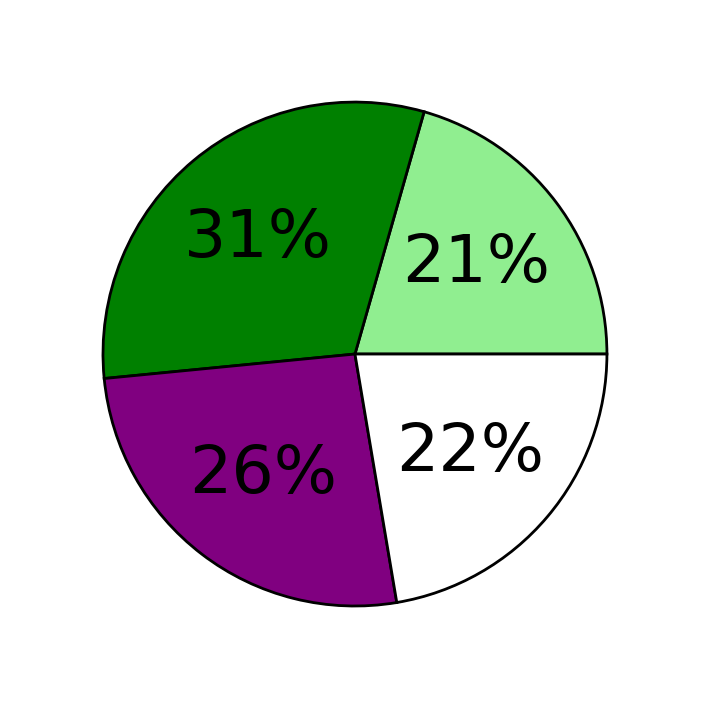

In [281]:
co = .03
idx0 = (df['cluster']==0) 
idx4 = (df['cluster']==4)
recover0 = ((data0['delta'] > co) & (data0['p'] < 1e-20))
recover4 = ((data1['delta'] > co) & (data1['p'] < 1e-20))

count_idx0 = SE_count[idx0].sum()
count_idx4 = SE_count[idx4].sum()
count_recover0 = SE_count[(recover0 | recover4) & (~(idx0 | idx4)) ].sum()
# count_recover4 = SE_count[(recover4 | recover0) & (~(idx0 | idx4 | recover0))].sum()
count_others = SE_count[~(idx0 | idx4 | recover0 | recover4)].sum()

fig, axs = init_subplots_exact(1, 1, fgsz=(40*mm, 40*mm), dpi = 200)
plt.pie([count_idx0, count_idx4, count_recover0, count_others],
       colors=['lightgreen', 'green', 'purple', 'white'], autopct='%1.0f%%', 
       wedgeprops={"edgecolor":"k", 'linewidth': .5, }
       )
fig.savefig('./plots/paper/fig4/pie.pdf')